1. EXPLORATIVE DATA ANALYSIS

IMPORTING LIBRARIES

In [2]:
# Data exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

# Text processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


DATA LOADING

In [3]:
# Load dataset from CSV file
df = pd.read_csv('edos_labelled_aggregated.csv')

In [4]:
# Length of the dataset
print(len(df))

20000


In [5]:
# Data cleaning
df = df.drop(columns=["rewire_id","label_category","label_vector","split"])
df = df.drop_duplicates()
df = df.dropna(subset=['text'])

DATA VISUALIZATION

In [6]:
# Print first 10 rows of the dataframe
df.head(10)

,text,label_sexist
0,"In Nigeria, if you rape a woman, the men rape ...",not sexist
1,"Then, she's a keeper. 😉",not sexist
2,This is like the Metallica video where the poo...,not sexist
3,woman?,not sexist
4,I bet she wished she had a gun,not sexist
5,Unlicensed day care worker reportedly tells co...,not sexist
6,[USER] Leg day is easy. Hot girls who wear min...,sexist
7,I don't know if you should avoid this one or e...,not sexist
8,I get a new pussy every other week or whenever...,sexist
9,I agree with that but at the same time I know ...,sexist


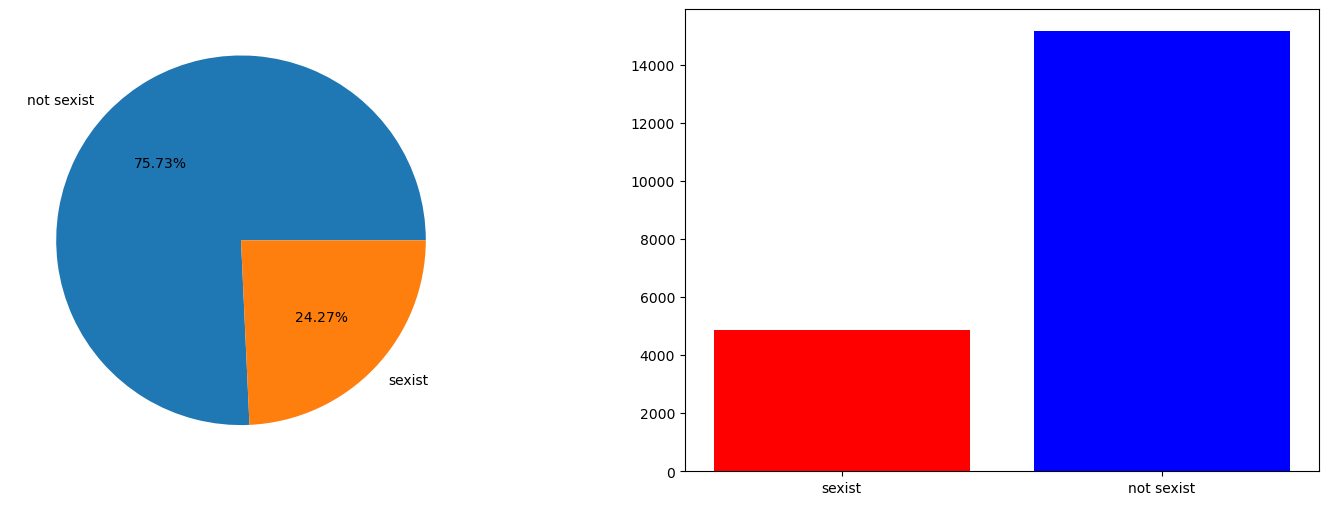

In [16]:
# Data Visualization
count = df['label_sexist'].value_counts()
labels = ["sexist", "not sexist"]
sizes = [count.get('sexist', 0), count.get('not sexist', 0)]
colors = ['red', 'blue']

# Visualize the distribution of labels
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Pie chart for label distribution
axs[0].pie(count,labels=["not sexist","sexist"], autopct='%1.2f%%')

# Bar chart for label distribution
axs[1].bar(labels, sizes, color=colors)

plt.show()

In [20]:
print("sexist:",df['label_sexist'].value_counts()['sexist'])
print("not sexist:",df['label_sexist'].value_counts()['not sexist'])

sexist: 4854
not sexist: 15146


2. PRE-PROCESSING

In [7]:
# Cleaning with regex

def clean_text(sentence):
    # Convert text to lower case
    sentence = sentence.lower()
    # Remove mentions (@username).
    sentence = re.sub(r'@\w+', '', sentence)
    # Remove URLs
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    # Remove hashtag (#hashtag)
    sentence = re.sub(r'#\w+', '', sentence)
    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # Remove text in square or round brackets
    sentence = re.sub(r'\[.*?\]|\(.*?\)', '', sentence)
    # Remove new line and tab characters
    sentence = re.sub(r'\n|\r|\t', ' ', sentence)
    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    # Remove special characters
    sentence = re.sub(r'[^\w\s]', '', sentence)
    # Remove HTML tags
    sentence = re.sub(r'<.*?>', '', sentence)
    # Remove email addresses
    sentence = re.sub(r'\S+@\S+', '', sentence)
    return sentence

In [8]:
# Tokenization
def tokenize(text):
    return nltk.word_tokenize(text)

# Remove stop words, punctuation, and convert to lowercase
def clean_tokens(tokens):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    return [token.lower() for token in tokens if token.isalnum() and token.lower() not in stop_words]

# Normalization
def normalize(tokens):
    return [token.lower() for token in tokens]

# Lemmatization
def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Stemming
def stem(tokens):
    stemmer = nltk.stem.PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

# Preprocessing pipeline
def nlp_pipeline(text):
    tokens = tokenize(text)
    tokens = clean_tokens(tokens)
    tokens = normalize(tokens)
    tokens = lemmatize(tokens)
    tokens = stem(tokens)
    return clean_text(' '.join(tokens))

In [9]:
# Apply preprocessing pipeline to the text data
df["text"] = df["text"].apply(lambda x: nlp_pipeline(x))

In [10]:
# Print some information about the corpus
corpus = df["text"].tolist()

# Tokenize the text data
tokenized_corpus = [word_tokenize(text) for text in corpus]

# Flatten the list of lists into a single list of tokens
tokens = [token for sublist in tokenized_corpus for token in sublist]

# Print corpus information
corpus_size = len(tokens)
vocabulary_size = len(set(tokens))
lexical_diversity = vocabulary_size / corpus_size

print(f"Size of the corpus     : {corpus_size}")
print(f"Size of the vocabulary : {vocabulary_size}")
print(f"Lexical diversity      : {lexical_diversity:.4f}")

Size of the corpus     : 237829
Size of the vocabulary : 16787
Lexical diversity      : 0.0706


TOP 10 MOST COMMON TOKENS

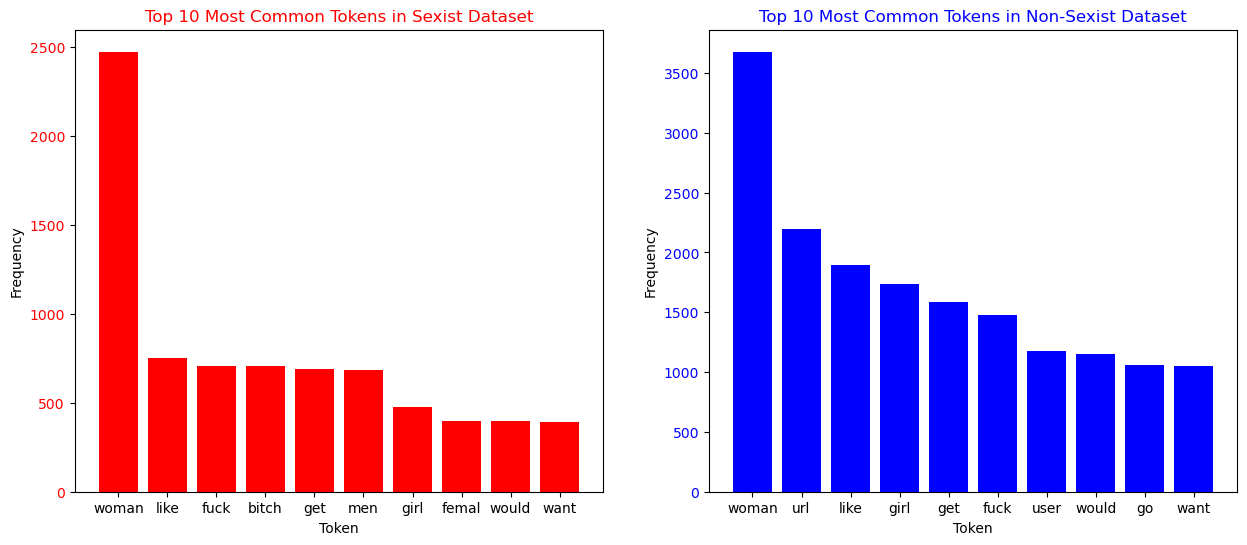

In [11]:
# Split the dataframe into sexist and non-sexist datasets
sexist_df = df[df["label_sexist"] == "sexist"]
non_sexist_df = df[df["label_sexist"] == "not sexist"]

# Tokenize the text data for sexist and non-sexist datasets
sexist_tokenized_corpus = [word_tokenize(text) for text in sexist_df["text"]]
non_sexist_tokenized_corpus = [word_tokenize(text) for text in non_sexist_df["text"]]

# Flatten the list of lists into a single list of tokens for sexist and non-sexist datasets
sexist_tokens = [token for sublist in sexist_tokenized_corpus for token in sublist]
non_sexist_tokens = [token for sublist in non_sexist_tokenized_corpus for token in sublist]

# Calculate the top 10 most common tokens for sexist and non-sexist datasets
sexist_token_counts = Counter(sexist_tokens)
non_sexist_token_counts = Counter(non_sexist_tokens)

sexist_most_common_tokens = sexist_token_counts.most_common(10)
non_sexist_most_common_tokens = non_sexist_token_counts.most_common(10)

# Visualize the top 10 most common tokens for sexist and non-sexist datasets
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

labels, values = zip(*sexist_most_common_tokens)
ax[0].bar(labels, values, color='red')
ax[0].set_xlabel('Token')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Top 10 Most Common Tokens in Sexist Dataset', color='red')
ax[0].tick_params(axis='y', labelcolor='red')

labels, values = zip(*non_sexist_most_common_tokens)
ax[1].bar(labels, values, color='blue')
ax[1].set_xlabel('Token')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Top 10 Most Common Tokens in Non-Sexist Dataset', color='blue')
ax[1].tick_params(axis='y', labelcolor='blue')

plt.show()

NUMBER OF WORDS

In [12]:
# Total number of tokens in each sentence
df['number_of_words'] = df["text"].apply(lambda x:len(str(x).split()))

In [13]:
# Display the first 10 samples of the dataset
df.sample(n=10)

,text,label_sexist,number_of_words
5700,user think lepen realli want win need go full ...,not sexist,24
16412,could know actual help shi instead construct b...,sexist,18
18048,usual want daughter black partner,not sexist,5
16234,good time sound like bitch shat repeatedli unl...,sexist,20
2885,said act like whore also url woman mani casual...,sexist,19
14532,egyptian lawyer jail say woman rip jean rape u...,not sexist,14
2738,fewer men engag casual sex also fewer woman so...,not sexist,23
762,fay buri as ground cale place park mope,not sexist,8
15108,check one paul seem birth control pill miss li...,not sexist,16
3781,latest q drop excel articl femal nativ califor...,not sexist,13


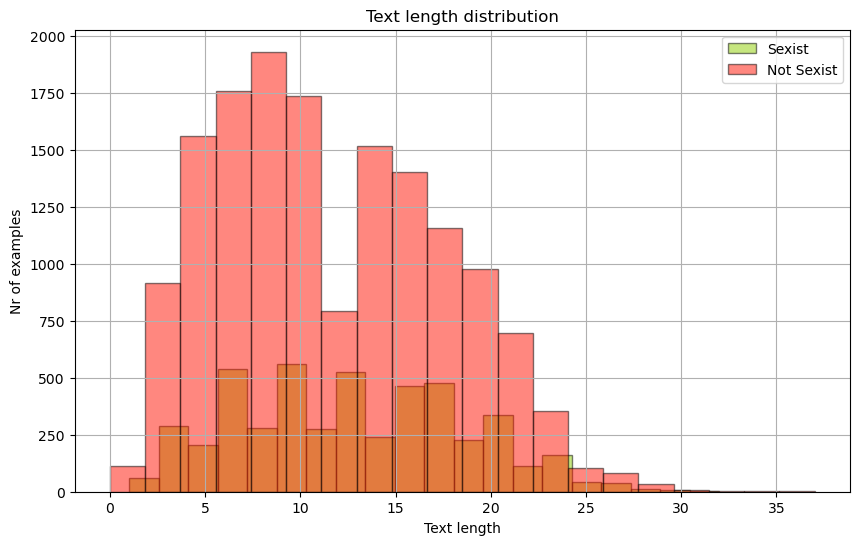

In [14]:
# Create copies of the datasets for easier manipulation
sexist_dataset = df[df['label_sexist'] == "sexist"].copy()
non_sexist_dataset = df[df['label_sexist'] == "not sexist"].copy()

# Calculate the number of words in each text
sexist_dataset['number_of_words'] = sexist_dataset['text'].apply(lambda x: len(x.split()))
non_sexist_dataset['number_of_words'] = non_sexist_dataset['text'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(sexist_dataset['number_of_words'], bins=20, alpha=0.5, label='Sexist', color='#8fce00', edgecolor='black')
plt.hist(non_sexist_dataset['number_of_words'], bins=20, alpha=0.5, label='Not Sexist', color='#ff1100', edgecolor='black')

# Add labels and title
plt.xlabel('Text length')
plt.ylabel('Nr of examples')
plt.title('Text length distribution')
plt.legend(loc='upper right')
plt.grid(True)

# Show plot
plt.show()

3. FEATURE EXTRACTION

In [15]:
# TF-IDF Vectorization

# Text feature vector
X = df["text"].tolist()

# Vector of labels
y = df["label_sexist"].tolist()

# Breakdown of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer()

# Transforming the text data into numerical feature vectors using TF-IDF
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


5. MODEL DEFINITION

In [16]:
# Logistic Regression
model = LogisticRegression()

# Training the model on the training data
model.fit(X_train, y_train)

LogisticRegression()

6. EVALUATION AND METRICS

>>>>> TFIDF + LOGISTIC REGRESSION <<<<<
Accuracy  : 0.828
Precision : 0.801
Recall    : 0.372
F1 Score  : 0.508


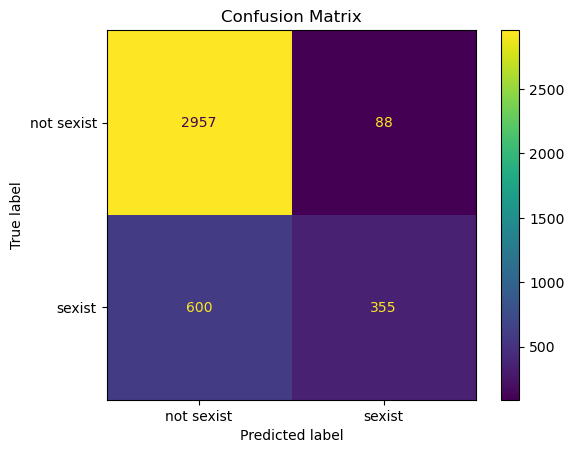

In [17]:
# Predictions about the test set
predictions = model.predict(X_test)

# Evaluation of the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='sexist')
recall = recall_score(y_test, predictions, pos_label='sexist')
f1 = f1_score(y_test, predictions, pos_label='sexist')
conf_matrix = confusion_matrix(y_test, predictions)

# Printing the evaluation metrics for TFIDF + Logistic Regression
print(">>>>> TFIDF + LOGISTIC REGRESSION <<<<<")
print(f'Accuracy  : {accuracy:.3f}')
print(f'Precision : {precision:.3f}')
print(f'Recall    : {recall:.3f}')
print(f'F1 Score  : {f1:.3f}')

# Visualizing the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()